In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

  with open('/content/drive/MyDrive/ML/Keyword Extraction/' + fn, 'wb') as f:
    f.write(uploaded[fn])

Saving papers.csv to papers.csv
User uploaded file "papers.csv" with length 210376592 bytes


In [1]:
import re
from typing import List, Dict, Union
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import numpy as np
import pandas as pd
!pip install dask[dataframe] --quiet
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from joblib import dump, Parallel, delayed
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [2]:
# Download required NLTK data
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

True

In [3]:
# Initialize stop words and lemmatizer
stop_words: set = set(stopwords.words('english'))
new_words: List[str] = ["fig", "figure", "image", "sample", "using",
                        "show", "result", "large",
                        "also", "one", "two", "three",
                        "four", "five", "seven", "eight", "nine"]
stop_words: List[str] = list(stop_words.union(new_words))
lemmatizer: WordNetLemmatizer = WordNetLemmatizer()

In [4]:
def pre_process(text: str) -> str:
    """
    Preprocess the input text by applying various cleaning and normalization techniques.

    Args:
        text (str): The input text to be preprocessed.

    Returns:
        str: The preprocessed text.

    This function applies the following steps:
    1. Convert to lowercase
    2. Remove HTML tags
    3. Remove special characters and digits
    4. Tokenize the text
    5. Remove stopwords
    6. Remove short words (less than 3 characters)
    7. Lemmatize the words

    Each step is crucial for standardizing the text and reducing noise in the data.
    Without these steps, the subsequent analysis would be less effective and potentially misleading.
    """
    # Convert to lowercase to standardize the text
    text = text.lower()

    # Remove HTML tags to clean up text from web sources
    text = re.sub("&lt;/?.*?&gt;", " &lt;&gt; ", text)

    # Remove special characters and digits to focus on meaningful words
    text = re.sub(r"(\d|\W)+", " ", text)

    # Tokenize the text into individual words
    words = text.split()

    # Remove stopwords, short words, and lemmatize to focus on significant, root words
    words = [lemmatizer.lemmatize(word) for word in words
             if word not in stop_words and len(word) >= 3]

    return ' '.join(words)

In [5]:
def sort_coo(coo_matrix) -> List[tuple]:
    """
    Sort the sparse matrix in descending order based on score.

    Args:
        coo_matrix: The sparse matrix to be sorted.

    Returns:
        List[tuple]: Sorted list of (idx, score) tuples.

    This function is crucial for identifying the most important features (words)
    based on their TF-IDF scores. It enables efficient extraction of top keywords.
    """
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

In [6]:
def extract_topn_from_vector(feature_names: List[str], sorted_items: List[tuple], topn: int = 10) -> Dict[str, float]:
    """
    Extract the top N items with their scores from the sorted vector.

    Args:
        feature_names (List[str]): List of feature names.
        sorted_items (List[tuple]): Sorted list of (idx, score) tuples.
        topn (int): Number of top items to extract.

    Returns:
        Dict[str, float]: Dictionary of top N features with their scores.

    This function is essential for creating a human-readable output of the most important keywords.
    It translates the numerical results into meaningful words with their corresponding importance scores.
    """
    sorted_items = sorted_items[:topn]
    results = {feature_names[idx]: round(score, 3) for idx, score in sorted_items}
    return results

In [7]:
def get_keywords(text: str) -> Dict[str, float]:
    """
    Extract keywords from the given text using TF-IDF.

    Args:
        text (str): The input text to extract keywords from.

    Returns:
        Dict[str, float]: Dictionary of top 10 keywords with their TF-IDF scores.

    This function encapsulates the entire process of keyword extraction for a single document.
    It's crucial for understanding the most important terms in any given text.
    """
    tf_idf_vector = vectorizer.transform([text])
    sorted_items = sort_coo(tf_idf_vector.tocoo())
    keywords = extract_topn_from_vector(feature_names, sorted_items, 10)
    return keywords

In [8]:
def get_keywords_batch(texts: List[str]) -> List[Dict[str, float]]:
    """
    Extract keywords from a batch of texts using TF-IDF in parallel.

    Args:
        texts (List[str]): List of input texts to extract keywords from.

    Returns:
        List[Dict[str, float]]: List of dictionaries, each containing top 10 keywords with their TF-IDF scores.

    This function leverages parallelization to efficiently process multiple documents simultaneously.
    It's particularly useful for large datasets where performance is a concern.
    """
    tf_idf_vectors = vectorizer.transform(texts)

    def process_vector(vector):
        sorted_items = sort_coo(vector.tocoo())
        return extract_topn_from_vector(feature_names, sorted_items, 10)

    return Parallel(n_jobs=-1)(delayed(process_vector)(vector) for vector in tf_idf_vectors)

In [9]:
def generate_wordcloud(text: str):
    """
    Generate and display a word cloud from the given text.

    Args:
        text (str): The input text to generate the word cloud from.

    This function provides a visual representation of the most frequent words in the corpus.
    It's an effective way to quickly grasp the main themes in a large body of text.
    """
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Keywords')
    plt.show()

In [10]:
def get_top_n_words(corpus: List[str], n: int = 20) -> Dict[str, int]:
    """
    Get the top N most frequent words in the corpus.

    Args:
        corpus (List[str]): List of documents.
        n (int): Number of top words to return.

    Returns:
        Dict[str, int]: Dictionary of top N words with their frequencies.

    This function is crucial for understanding the most common terms across the entire corpus.
    It provides insights into the overall themes and frequently discussed topics in the dataset.
    """
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return dict(words_freq[:n])

In [11]:
# Load the dataset using Dask for better performance with large datasets
df = dd.read_csv('/content/drive/MyDrive/ML/Keyword Extraction/papers.csv',
                 blocksize=None,
                 dtype={'event_type': 'object'})

In [16]:
# Define a function to preprocess a partition
def preprocess_partition(partition):
    """
    Preprocess a partition of the DataFrame.

    Args:
        partition (dd.DataFrame): A partition of the Dask DataFrame.

    Returns:
        pd.Series: Preprocessed text data.

    This function applies the pre_process function to the 'paper_text' column
    of each partition, enabling parallel processing of the dataset.
    """
    return partition['paper_text'].fillna('').apply(pre_process)

In [17]:
# Apply preprocessing to each partition in parallel
with ProgressBar():
    print("Preprocessing data...")
    docs = df.map_partitions(preprocess_partition, meta=('paper_text', 'object')).compute()

Preprocessing data...
[########################################] | 100% Completed | 100.62 s


In [18]:
# Convert to pandas Series for further processing
docs = pd.Series(docs.tolist())

In [19]:
# Display sample of preprocessed data
print("Sample of preprocessed data:")
docs.head()

Sample of preprocessed data:


,0
0,self organization associative database applica...
1,mean field theory layer visual cortex applicat...
2,storing covariance associative long term poten...
3,bayesian query construction neural network mod...
4,neural network ensemble cross validation activ...


In [20]:
# Create and fit TfidfVectorizer
vectorizer = TfidfVectorizer(max_df=0.85, max_features=5000, ngram_range=(1,3))
tfidf_matrix = vectorizer.fit_transform(docs)

In [21]:
# Get feature names
feature_names = vectorizer.get_feature_names_out()

In [22]:
# Save the vectorizer and feature names using joblib
dump(vectorizer, '/content/drive/MyDrive/ML/Keyword Extraction/keywords-tfidf-vectorizer.joblib')
dump(feature_names, '/content/drive/MyDrive/ML/Keyword Extraction/keywords-feature-names.joblib')

['/content/drive/MyDrive/ML/Keyword Extraction/keywords-feature-names.joblib']

In [23]:
# Example usage with parallelization
sample_texts = docs.iloc[:100]  # Process 100 documents as an example
keywords_batch = get_keywords_batch(sample_texts)

print("\nExtracted keywords for the first 5 documents:")
for i, keywords in enumerate(keywords_batch[:5]):
    print(f"\nDocument {i + 1}:")
    for k, v in keywords.items():
        print(f"{k}: {v}")


Extracted keywords for the first 5 documents:

Document 1:
robot: 0.377
associative: 0.235
database: 0.232
camera: 0.202
letter: 0.177
learning machine: 0.161
position: 0.156
obstacle: 0.145
window: 0.139
self: 0.137

Document 2:
cell: 0.499
cortical: 0.409
synapsis: 0.363
mean field: 0.252
eye: 0.216
network: 0.206
activity: 0.192
field: 0.128
inhibitory: 0.108
layer: 0.108

Document 3:
associative: 0.36
synaptic: 0.33
weak: 0.321
hippocampus: 0.286
stimulation: 0.224
input: 0.206
pathway: 0.197
postsynaptic: 0.188
stimulus: 0.184
phase: 0.171

Document 4:
loss: 0.374
query: 0.371
den: 0.262
future: 0.154
bayesian: 0.139
observation: 0.135
posterior: 0.133
input: 0.132
square: 0.131
loss function: 0.128

Document 5:
ensemble: 0.539
generalization error: 0.365
ambiguity: 0.321
generalization: 0.24
network: 0.217
error: 0.204
active learning: 0.195
cross validation: 0.146
active: 0.134
individual: 0.129


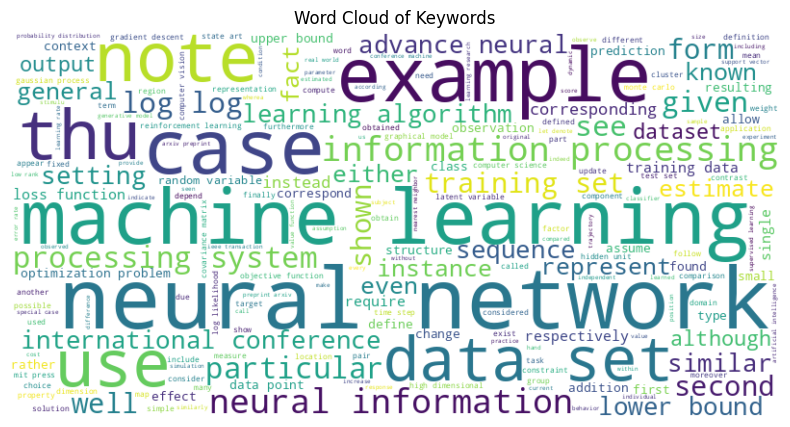

In [24]:
# Word cloud visualization
generate_wordcloud(' '.join(docs))

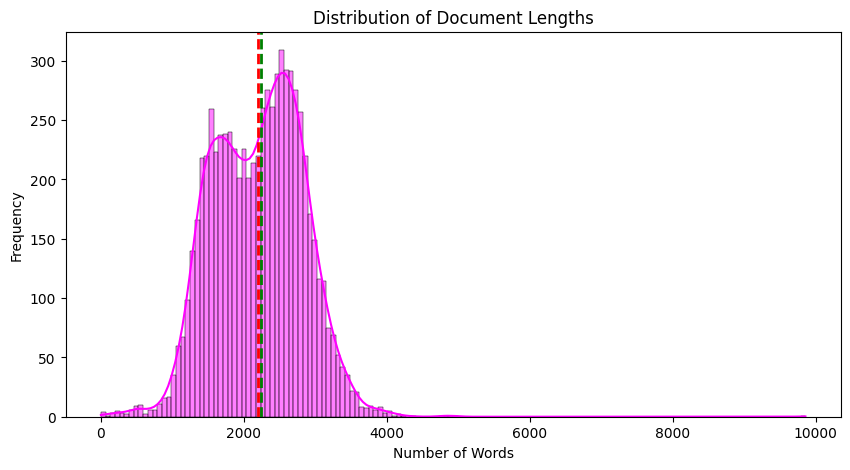

In [34]:
# Document length distribution
doc_lengths = docs.str.split().str.len()
plt.figure(figsize=(10, 5))
sns.histplot(doc_lengths, bins=150, kde=True, color='magenta')

plt.axvline(doc_lengths.mean(), color='red', linestyle='dashed', linewidth=2)
plt.axvline(doc_lengths.median(), color='green', linestyle='dashed', linewidth=2)

plt.title('Distribution of Document Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

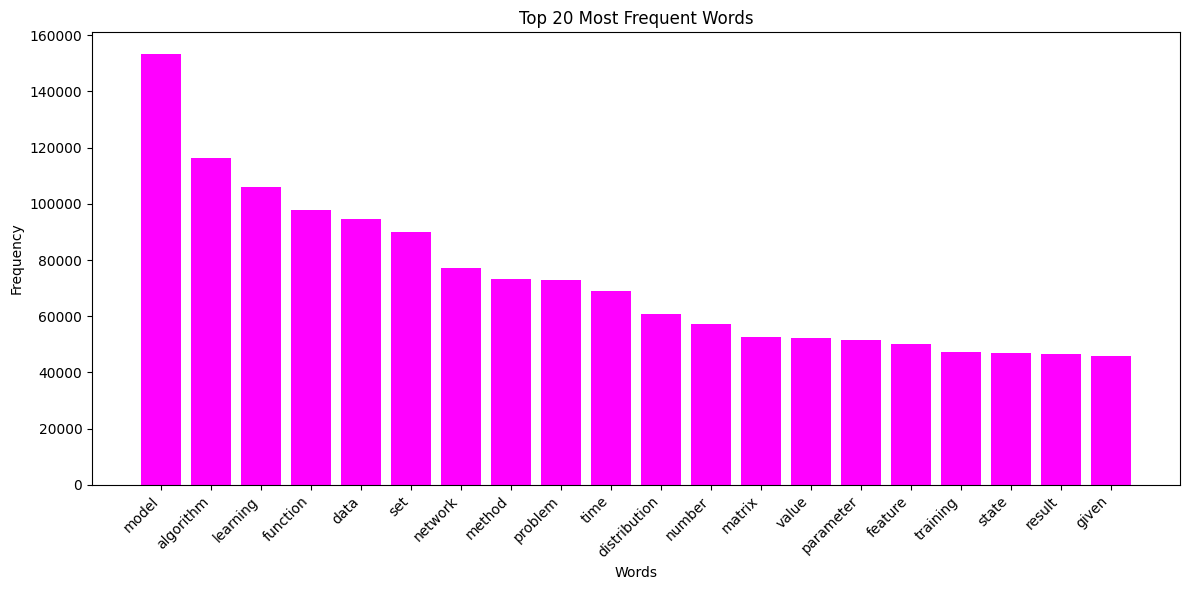

Keyword extraction and analysis complete.


In [36]:
# Top N most frequent words
top_words = get_top_n_words(docs)
plt.figure(figsize=(12, 6))
plt.bar(top_words.keys(), top_words.values(), color='magenta')
plt.title('Top 20 Most Frequent Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("Keyword extraction and analysis complete.")